# Time Series Forecasting with Dart TCN model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional
from darts import models, backtesting
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
from custom_code import sumape, create_fortnights
%matplotlib inline

In [2]:
pd.plotting.register_matplotlib_converters()


# Dart

## Train one model for each entity

In [3]:
df_all = pd.read_csv("efecty_drawdowns.csv", dtype={"y":float, "entity_id":int, "ds":str}, index_col=0)
df_all["ds"] = pd.to_datetime(df_all["ds"], format='%Y-%m-%d')
df_all.head()

,ds,y,entity_id
0,2019-02-05,3383730.0,995152
1,2019-02-05,988994.0,992133
2,2019-02-05,597150.0,995388
3,2019-02-05,50000.0,902343
4,2019-02-05,1426410.0,993733


In [4]:
len(df_all.entity_id.unique())

254

## Fill missing values
TimeSeries add missing date with nan values, and you have to fillna values with `auto_fillna` function

In [5]:
def create_time_series(df:pd.DataFrame) -> TimeSeries:
    """
    Create a time series filling missing dates and filling the values of those mising dates.

    Parameters
    ----------
    df
        pandas dataframe.
    Returns
    -------
    TimeSeries
        The TimeSeries filled.
    """
    series = TimeSeries.from_dataframe(df, "ds", "y" )
    series = missing_values.auto_fillna(series, method="slinear")
    return series

In [6]:
def create_quincenas_ts(series: TimeSeries) -> TimeSeries: 
    """
    Train a TCN Model for the given time series and hyperparameters.
    
    Parameters
    ----------
    epochs
        number of epochs to train 
    pred_length
        length of the prediction
    entity_name
        name of the entity to add it to the model
    train_transformed
        TimeSeries to train with
    val_transformed
        TimeSeries for validation
    Returns
    -------
    TCNModel
        A TCNModel to trained
    """
    df_quincenas = create_fortnights(series.pd_dataframe().index[0].date(), series.pd_dataframe().index[-1].date())
    df_quincenas.set_index("ds", inplace=True)
    df_quincenas.replace(to_replace="quincena", value=1, inplace=True)

    df_quincena_full = pd.DataFrame({
        "ds":pd.date_range(start=series.pd_dataframe().index[0].date(), end=series.pd_dataframe().index[-1].date()),
        "holiday":0
    })
    df_quincena_full.set_index("ds", inplace=True)
    df_quincena_full.update(df_quincenas)

    return TimeSeries.from_dataframe(df_quincena_full, time_col=None, value_cols="holiday" )

In [7]:
def preprocess_data(series: TimeSeries, date_division: str) -> (TimeSeries , TimeSeries , TimeSeries):
    """
    For a gived TimeSeries and a date division will normalize and add quincenas
    and then split the entire ts in val and train.

    Parameters
    ----------
    series
        The TimeSeries to procces
    date_division
        A string of dateTime for split the series.
    Returns
    -------
    TimeSeries
        The gived TimeSeries with attributes and normalized
    TimeSeries
        A new TimeSeries, for training.
    TimeSeries
        A new TimeSeries, for validation
    """
    
    ts_enhanced = series.add_holidays(country_code="COL")
    quincena_ts = create_quincenas_ts(ts_enhanced)
    ts_enhanced = ts_enhanced.stack(quincena_ts)
    train, val = ts_enhanced.split_after(pd.Timestamp(date_division))
    transformer = ScalerWrapper()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    ts_transformed = transformer.transform(ts_enhanced)

    return ts_transformed, train_transformed, val_transformed


In [8]:
def train_model(
    epochs:int, 
    pred_length: int,
    entity_name:str, 
    train_transformed:TimeSeries , 
    val_transformed:TimeSeries) -> models.TCNModel :
    """
    Train a TCN Model for the given time series and hyperparameters.
    
    Parameters
    ----------
    epochs
        number of epochs to train 
    pred_length
        length of the prediction
    entity_name
        name of the entity to add it to the model
    train_transformed
        TimeSeries to train with
    val_transformed
        TimeSeries for validation
    Returns
    -------
    TCNModel
        A TCNModel to trained
    """
    my_model_2 = models.TCNModel(
        input_size = 3 ,
        n_epochs = epochs,
        input_length = 15,
        output_length = pred_length,
        dropout = 0.1,
        dilation_base = 1,
        weight_norm = True,
        kernel_size = 7,
        num_filters = 4,
        model_name="TCN_" + entity_name
    )
    # fit the model
    my_model_2.fit(train_transformed, val_series=val_transformed, target_indices=[0])

    return my_model_2

In [9]:
def predict_multivariante_model(
    val_transformed:TimeSeries,
    model:models.TCNModel,
    pred_length: int ) -> float:
    """
    predict for a gived TCN model and a multivariante TimeSeries, return the sumape error

    Parameters
    ----------
    val_transformed
        number of epochs to train 
    model
        length of the prediction
    pred_length
        name of the entity to add it to the model
    
    Returns
    -------
    float
        the error of the prediction in the model
    """


    prediction = model.predict(pred_length, use_full_output_length=True)
    error = sumape(
        prediction.slice_intersect(val_transformed), val_transformed.univariate_component(0)
        )
    return error

In [10]:
entities = df_all.entity_id.unique()
error_dict_3 = {} # change the pred_length and rerun it
date_division = "20200113"
epochs = 200
pred_length = 3 # has to be less than input_length
# 5 / 3 
a = 0

for entity in entities:
    df_entity = df_all[df_all.entity_id == entity]
    if len(df_entity) > 370 :
        print(entity)
        try :
            ts, train, val = preprocess_data(create_time_series(df_entity), date_division)
            trained_model = train_model(200, pred_length, str(entity), train, val)
            error = predict_multivariante_model(val, trained_model, pred_length)
            print(entity, error)
            error_dict_3[entity] = error
        except:
            print("error in entity: " + str(entity))
            pass

992133
[2020-07-23 15:02:35,286] INFO | darts.models.tcn_model | Number of layers chosen: 2
992133 49.678959595611076
992807
[2020-07-23 15:03:14,068] ERROR | darts.timeseries | ValueError: Could not infer explicit frequency. Observed frequencies: {'D', '2D'}. Is Series too short (n=2)?
error in entity: 992807
997611
[2020-07-23 15:03:14,498] INFO | darts.models.tcn_model | Number of layers chosen: 2
997611 100.0
992440
[2020-07-23 15:03:56,698] INFO | darts.models.tcn_model | Number of layers chosen: 2
992440 44.04296881313929
901703
[2020-07-23 15:04:37,824] INFO | darts.models.tcn_model | Number of layers chosen: 2
901703 41.25191763256943
904458
[2020-07-23 15:05:18,895] INFO | darts.models.tcn_model | Number of layers chosen: 2
904458 15.167049209226633
995567
[2020-07-23 15:05:58,042] INFO | darts.models.tcn_model | Number of layers chosen: 2
995567 21.211260327071162
10434
[2020-07-23 15:06:32,493] INFO | darts.models.tcn_model | Number of layers chosen: 2
10434 35.4766310783933

In [11]:
# error_dict_12

In [12]:
error_dict_3

{992133: 49.678959595611076,
 997611: 100.0,
 992440: 44.04296881313929,
 901703: 41.25191763256943,
 904458: 15.167049209226633,
 995567: 21.211260327071162,
 10434: 35.47663107839332,
 999100: 21.062553948519113,
 995627: 44.62089548099634,
 991476: 44.975735267391336,
 70015: 39.900931978691695,
 995363: 30.613348652801736,
 992521: 47.629546243528196,
 904095: 33.14630526812899,
 18001: 21.4072240654673,
 996986: 32.49975942782687,
 993619: 37.568587080299395,
 46001: 11.754186113678394,
 996490: 30.38019280079588,
 902247: 30.66322791554309,
 903545: 16.1473695731815,
 800263: 41.75344742189638,
 902647: 52.17879701369187,
 904236: 31.783611546063266,
 800244: 24.22318190411239,
 991947: 52.466361816979614,
 900333: 11.296263090253502,
 992032: 15.657689515132395,
 902987: 67.22745102284577,
 904446: 12.997884493100944,
 900057: 22.01089038842498,
 903787: 10.15212693373368,
 904954: 46.955783094851625,
 904872: 30.11545493022385}

Text(0.5, 1.0, 'Average SuMAPE Error TCN: 34.35%')

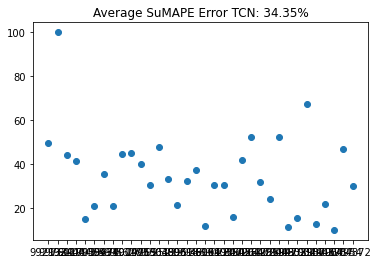

In [13]:
x = [*map(str,error_dict_3.keys())]
y = error_dict_3.values()
plt.scatter(x,y )
plt.title('Average SuMAPE Error TCN: {:.2f}%'.format(np.mean(list(y))))